In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_2frac_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_2frac_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)


In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [7]:
frac_params = pd.read_csv('frac_params_2frac_sys.csv')
frac_params['dt1'] *= 2.5
frac_params['e1'] *= 6.3
frac_params['dt2'] *= 2.5
frac_params['e2'] *= 6.3
frac_params = np.array(frac_params[['dn1','dt1','dn2','dt2','e1','e2']])

In [8]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [9]:
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,6) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x

In [10]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(6,8,6,4, prob=0.01)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [11]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.08340716 
	Test Loss:	 0.114087425
epoch # 2 :
	Train Loss:	 0.024008563 
	Test Loss:	 0.072911
epoch # 3 :
	Train Loss:	 0.015048452 
	Test Loss:	 0.028937947
epoch # 4 :
	Train Loss:	 0.012982642 
	Test Loss:	 0.014809332
epoch # 5 :
	Train Loss:	 0.0114478925 
	Test Loss:	 0.011744412
epoch # 6 :
	Train Loss:	 0.010183951 
	Test Loss:	 0.01013077
epoch # 7 :
	Train Loss:	 0.009399385 
	Test Loss:	 0.009203193
epoch # 8 :
	Train Loss:	 0.008603501 
	Test Loss:	 0.0083823195
epoch # 9 :
	Train Loss:	 0.007832191 
	Test Loss:	 0.0075965896
epoch # 10 :
	Train Loss:	 0.0072350027 
	Test Loss:	 0.0069276094
epoch # 11 :
	Train Loss:	 0.0064152004 
	Test Loss:	 0.0062060347
epoch # 12 :
	Train Loss:	 0.0058106063 
	Test Loss:	 0.0055002244
epoch # 13 :
	Train Loss:	 0.0050815707 
	Test Loss:	 0.0048659425
epoch # 14 :
	Train Loss:	 0.004514628 
	Test Loss:	 0.0043601366
epoch # 15 :
	Train Loss:	 0.004011544 
	Test Loss:	 0.003836437
epoch # 16 :
	Train Loss:	 

epoch # 123 :
	Train Loss:	 0.00043110672 
	Test Loss:	 0.0005290141
epoch # 124 :
	Train Loss:	 0.00042788108 
	Test Loss:	 0.00054181507
epoch # 125 :
	Train Loss:	 0.00043463035 
	Test Loss:	 0.0005678191
epoch # 126 :
	Train Loss:	 0.00045720197 
	Test Loss:	 0.0005744482
epoch # 127 :
	Train Loss:	 0.00040211887 
	Test Loss:	 0.00055341783
epoch # 128 :
	Train Loss:	 0.00040609235 
	Test Loss:	 0.0005340535
epoch # 129 :
	Train Loss:	 0.00045068347 
	Test Loss:	 0.0005334943
epoch # 130 :
	Train Loss:	 0.00042833437 
	Test Loss:	 0.00053645216
epoch # 131 :
	Train Loss:	 0.0003988363 
	Test Loss:	 0.0005191656
epoch # 132 :
	Train Loss:	 0.00040409635 
	Test Loss:	 0.00055582676
epoch # 133 :
	Train Loss:	 0.0004086025 
	Test Loss:	 0.00056123076
epoch # 134 :
	Train Loss:	 0.0004211089 
	Test Loss:	 0.00055710925
epoch # 135 :
	Train Loss:	 0.00042447879 
	Test Loss:	 0.00052189274
epoch # 136 :
	Train Loss:	 0.00041209487 
	Test Loss:	 0.00054605555
epoch # 137 :
	Train Loss:	 0

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

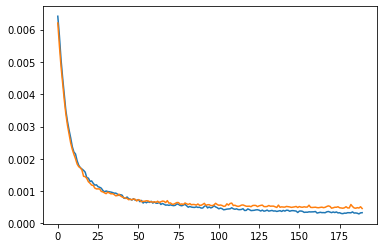

In [13]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

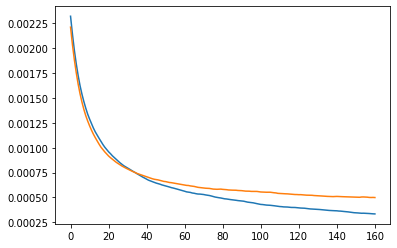

In [14]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [15]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\nReal value\nDifference\n')

sum_dn1_sq = 0.0
sum_dt1_sq = 0.0
sum_dn1 = 0.0
sum_dt1 = 0.0
sum_dn1_real = 0.0
sum_dt1_real = 0.0
sum_e1 = 0.0
sum_e1_sq = 0.0
sum_e1_real = 0.0

sum_dn2_sq = 0.0
sum_dt2_sq = 0.0
sum_dn2 = 0.0
sum_dt2 = 0.0
sum_dn2_real = 0.0
sum_dt2_real = 0.0
sum_e2 = 0.0
sum_e2_sq = 0.0
sum_e2_real = 0.0

for i in range(300):
    # dt1
    pred[i][1] /= 2.5
    y_val[i][1] /= 2.5
    
    # e1
    pred[i][4] /= 6.3
    y_val[i][4] /= 6.3
    
    # dt2
    pred[i][3] /= 2.5
    y_val[i][3] /= 2.5
    
    # e2
    pred[i][5] /= 6.3
    y_val[i][5] /= 6.3
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\n',y_val[i],'\n',abs(pred[i]-y_val[i]),'\n')
    
    sum_dn1_sq += dif[0]**2
    sum_dt1_sq += dif[1]**2
    sum_e1_sq += dif[4]**2
    sum_dn1 += dif[0]
    sum_dt1 += dif[1]
    sum_e1 += dif[4]
    sum_dn2_sq += dif[2]**2
    sum_dt2_sq += dif[3]**2
    sum_e2_sq += dif[5]**2
    sum_dn2 += dif[2]
    sum_dt2 += dif[3]
    sum_e2 += dif[5]
    
    sum_dn1_real += y_val[i][0]
    sum_dt1_real += y_val[i][1]
    sum_e1_real += y_val[i][4]
    sum_dn2_real += y_val[i][2]
    sum_dt2_real += y_val[i][3]
    sum_e2_real += y_val[i][5]
    
mean_dn1 = sum_dn1/300
mean_dt1 = sum_dt1/300
mean_e1 = sum_e1/300
mean_dn1_sq = sum_dn1_sq/300
mean_dt1_sq = sum_dt1_sq/300
mean_e1_sq = sum_e1_sq/300
relative_dn1 = sum_dn1/sum_dn1_real
relative_dt1 = sum_dt1/sum_dt1_real
relative_e1 = sum_e1/sum_e1_real

mean_dn2 = sum_dn2/300
mean_dt2 = sum_dt2/300
mean_e2 = sum_e2/300
mean_dn2_sq = sum_dn2_sq/300
mean_dt2_sq = sum_dt2_sq/300
mean_e2_sq = sum_e2_sq/300
relative_dn2 = sum_dn2/sum_dn2_real
relative_dt2 = sum_dt2/sum_dt2_real
relative_e2 = sum_e2/sum_e2_real

Predicted
Real value
Difference

[0.05221191 0.10975146 0.0330783  0.13217819 0.00858907 0.00499035] 
 [0.05739814 0.18541272 0.03882725 0.0450153  0.00908299 0.00614423] 
 [0.00518623 0.07566126 0.00574895 0.08716289 0.00049391 0.00115388] 

[0.15173286 0.04082857 0.00338479 0.04568299 0.02207354 0.0020018 ] 
 [0.14326808 0.0504863  0.00992968 0.03376978 0.0226715  0.00157132] 
 [0.00846478 0.00965772 0.00654489 0.01191321 0.00059796 0.00043048] 

[0.38442597 0.13519005 0.01116694 0.15977743 0.06070928 0.00089408] 
 [3.8801473e-01 1.3673267e-01 1.4542630e-03 1.5493271e-01 6.1401512e-02
 2.3013000e-04] 
 [0.00358877 0.00154261 0.00971267 0.00484473 0.00069223 0.00066395] 

[0.4890447  0.17302176 0.27590486 0.09337039 0.0775238  0.04344475] 
 [0.4949551  0.17441742 0.2724696  0.09601568 0.07832433 0.04311704] 
 [0.0059104  0.00139566 0.00343525 0.00264529 0.00080053 0.00032771] 

[0.1369458  0.04482715 0.3309852  0.11614321 0.02238079 0.05242527] 
 [0.13789359 0.04859238 0.3259502  0.11

 [0.10765368 0.03793612 0.41251734 0.14536716 0.01703569 0.06527893] 
 [0.00676066 0.0072789  0.004915   0.00285627 0.00038376 0.00069954] 

[0.613296   0.21664551 0.16324687 0.05840087 0.09745203 0.02637334] 
 [0.61361426 0.21623178 0.16617905 0.0585599  0.09710158 0.02629706] 
 [3.1828880e-04 4.1373074e-04 2.9321760e-03 1.5903264e-04 3.5044551e-04
 7.6284632e-05] 

[0.05788162 0.0593968  0.2920168  0.10173933 0.01002994 0.04654216] 
 [0.05984951 0.06631313 0.29225248 0.10298697 0.00947091 0.04624758] 
 [0.0019679  0.00691634 0.00023568 0.00124764 0.00055904 0.00029458] 

[0.4807854  0.17023769 0.46137577 0.16000287 0.07642066 0.07303996] 
 [0.48086026 0.16945055 0.4511918  0.15899566 0.07609389 0.07139899] 
 [7.4863434e-05 7.8713894e-04 1.0183960e-02 1.0072142e-03 3.2677501e-04
 1.6409680e-03] 

[0.06912614 0.10417249 0.42693666 0.14768262 0.01173971 0.06719126] 
 [0.07409985 0.10988183 0.4222897  0.14881083 0.01172596 0.06682537] 
 [4.9737096e-03 5.7093427e-03 4.6469569e-03 1.128211

[0.38355    0.13718784 0.19699007 0.06880228 0.06116948 0.03076754] 
 [0.38864693 0.13695545 0.18810101 0.06628499 0.06150155 0.0297661 ] 
 [0.00509694 0.00023238 0.00888906 0.00251729 0.00033207 0.00100144] 

[0.28618476 0.1028388  0.1604523  0.05196522 0.04614082 0.0249522 ] 
 [0.28984347 0.10213806 0.1560454  0.0549889  0.04586637 0.02469345] 
 [0.00365871 0.00070074 0.0044069  0.00302368 0.00027444 0.00025875] 

[0.4374217  0.15371397 0.1797235  0.06005093 0.06923872 0.02810024] 
 [0.43946615 0.15486366 0.16797477 0.0591927  0.06954346 0.02658122] 
 [0.00204444 0.00114968 0.01174873 0.00085823 0.00030474 0.00151902] 

[0.08306706 0.13217059 0.05843814 0.11480995 0.01257689 0.00953788] 
 [0.09270424 0.19657192 0.08047956 0.04401015 0.01467001 0.01273551] 
 [0.00963718 0.06440133 0.02204142 0.07079979 0.00209313 0.00319763] 

[0.53927535 0.18942448 0.08391658 0.16014531 0.08637173 0.01284599] 
 [0.53330946 0.18793313 0.09784973 0.16003287 0.08439372 0.01548426] 
 [0.00596589 0.001491

In [16]:
print('Dn1 mean: ', mean_dn1)
print('Dt1 mean: ', mean_dt1)
print('e1 mean: ', mean_e1)
print('Dn2 mean: ', mean_dn2)
print('Dt2 mean: ', mean_dt2)
print('e2 mean: ', mean_e2)
print('Dn1 MSE: ', math.sqrt(mean_dn1_sq))
print('Dt1 MSE: ', math.sqrt(mean_dt1_sq))
print('e1 MSE: ', math.sqrt(mean_e1_sq))
print('Dn2 MSE: ', math.sqrt(mean_dn2_sq))
print('Dt2 MSE: ', math.sqrt(mean_dt2_sq))
print('e2 MSE: ', math.sqrt(mean_e2_sq))
print('Dn1 Relative: ', relative_dn1)
print('Dt1 Relative: ', relative_dt1)
print('e1 Relative: ', relative_e1)
print('Dn2 Relative: ', relative_dn2)
print('Dt2 Relative: ', relative_dt2)
print('e2 Relative: ', relative_e2)

Dn1 mean:  0.004996021086505304
Dt1 mean:  0.00492631619485716
e1 mean:  0.0006632840594587227
Dn2 mean:  0.008766911483059327
Dt2 mean:  0.0056766981662561495
e2 mean:  0.0013187071995829076
Dn1 MSE:  0.006780014357224793
Dt1 MSE:  0.013822808804247242
e1 MSE:  0.0010105570348404682
Dn2 MSE:  0.01241940445384019
Dt2 MSE:  0.01369164111541919
e2 MSE:  0.002091538793533639
Dn1 Relative:  0.016416679368076514
Dt1 Relative:  0.04011549803526503
e1 Relative:  0.013773038473209985
Dn2 Relative:  0.028431009957783644
Dt2 Relative:  0.04399126297198183
e2 Relative:  0.02702484366634053


In [17]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e1 (crack density)\tDn1 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][4]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][0]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e1 (crack density)	Dn1 formula	Predicted value	Difference
0.008589074 	 0.05427695695957738 	 0.052211907 	 0.002065050198646362
0.022073539 	 0.13948937017598861 	 0.15173286 	 0.012243491819708407
0.06070928 	 0.38364029917512693 	 0.38442597 	 0.0007856687566205056
0.0775238 	 0.48989632947562367 	 0.4890447 	 0.00085163338301808
0.02238079 	 0.14143098072414462 	 0.1369458 	 0.00448518173103396
0.018868938 	 0.11923852776629358 	 0.116684705 	 0.0025538227472963887
0.0075257486 	 0.04755748182584314 	 0.041348025 	 0.006209456623091983
0.037849672 	 0.23918352803462 	 0.23360294 	 0.005580586998395642
0.0011834608 	 0.0074786469002654805 	 0.012288425 	 0.004809778217465614
0.017975243 	 0.11359099694318713 	 0.107313156 	 0.006277840815257438
0.055670585 	 0.3517992704100642 	 0.34465036 	 0.007148912448409539
0.03611568 	 0.22822590646985122 	 0.22852029 	 0.00029438259360245467
0.020688228 	 0.13073517301913454 	 0.12280461 	 0.007930561097824113
0.054049086 	 0.3415525235585205

0.08018191 	 0.5066937549111614 	 0.50248176 	 0.004211996316648481
0.02833461 	 0.17905497304487614 	 0.17664152 	 0.002413449206832924
0.02119065 	 0.13391013247945321 	 0.13446733 	 0.0005572010757683432
0.07837284 	 0.49526170681078896 	 0.49390045 	 0.0013612587269113963
0.018465122 	 0.11668669306080856 	 0.1163602 	 0.00032649062912978866
0.0072510825 	 0.045821783529143935 	 0.03780925 	 0.008012534515481597
0.047551516 	 0.30049241707232865 	 0.3000089 	 0.00048352405932816644
0.007251392 	 0.045823740394413226 	 0.041894466 	 0.003929274709522479
0.010235073 	 0.0646785227517948 	 0.06222468 	 0.0024538440565929215
0.065902054 	 0.41645501701571713 	 0.41562375 	 0.0008312627527929384
0.028416438 	 0.17957206807131407 	 0.17738287 	 0.0021891965627157395
0.038550954 	 0.24361514223106046 	 0.22584489 	 0.01777025235183377
0.03374794 	 0.21326344978192932 	 0.2053307 	 0.007932750099693603
0.0695888 	 0.43975269570704667 	 0.44424468 	 0.004491987081802207
0.026957244 	 0.1703

In [18]:
print('Mean difference between predicted value and formula for Dn1: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn1: ', sum_dif/abs(sum_dn1_real))

Mean difference between predicted value and formula for Dn1:  0.004225478614144417
Relative difference between predicted value and formula for Dn1:  0.01388471473277869


In [19]:
# проверим как предсказанные значения связаны с аналитической формулой
print('e2 (crack density)\tDn2 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][5]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][2]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e2 (crack density)	Dn2 formula	Predicted value	Difference
0.0049903467 	 0.03153551060007166 	 0.033078298 	 0.0015427873726074764
0.0020018031 	 0.012649999572653113 	 0.0033847913 	 0.009265208258051215
0.0008940839 	 0.005649986468320332 	 0.011166938 	 0.005516951180929698
0.043444753 	 0.27454053460936656 	 0.27590486 	 0.0013643294634331227
0.052425265 	 0.33129111051674803 	 0.3309852 	 0.0003059220325561385
0.046065174 	 0.2910997698157951 	 0.2898134 	 0.0012863705009147353
0.0048083565 	 0.03038545940998097 	 0.030719586 	 0.00033412630674342636
0.064828426 	 0.40967043270762443 	 0.4135657 	 0.003895262578172687
0.003265644 	 0.020636592050727123 	 0.019019186 	 0.0016174055539925035
0.0012099317 	 0.0076459243045991715 	 0.008744307 	 0.001098382557755107
0.09201802 	 0.5814897242739996 	 0.5800495 	 0.001440209503491774
0.03206293 	 0.2026153483923264 	 0.20836896 	 0.0057536086503676975
0.016737817 	 0.10577132801523834 	 0.10601773 	 0.00024640311488480227
0.06995103 	 0

0.04672779 	 0.2952870495204462 	 0.29270282 	 0.002584225643111615
0.014916237 	 0.09426021667267732 	 0.09918242 	 0.004922202806215956
0.06249018 	 0.39489435198766637 	 0.39616454 	 0.001270184488468884
0.08409811 	 0.5314413854300554 	 0.5332191 	 0.0017777136147444361
0.015008056 	 0.09484044340962262 	 0.08761146 	 0.007228984214008763
0.07605923 	 0.4806412807453941 	 0.4816296 	 0.000988329316251424
0.09970737 	 0.6300810489194828 	 0.6301797 	 9.865431614342057e-05
0.09567209 	 0.6045808992403097 	 0.60433203 	 0.0002488694208211406
0.009850236 	 0.06224661887475382 	 0.060198657 	 0.0020479616601122505
0.036476348 	 0.23050507480563298 	 0.23435217 	 0.003847096615418044
0.04644446 	 0.2934965972507158 	 0.29572806 	 0.0022314603721937387
0.06680193 	 0.4221415909792642 	 0.4247136 	 0.0025720206235190224
0.06988648 	 0.44163382881909063 	 0.444205 	 0.002571157276337832
0.060898837 	 0.3848381714441519 	 0.38791794 	 0.0030797644040841954
0.0656493 	 0.41485779121372035 	 0

0.067565605 	 0.42696749734286715 	 0.42688665 	 8.084940318514588e-05


In [20]:
print('Mean difference between predicted value and formula for Dn2: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn2: ', sum_dif/abs(sum_dn2_real))

Mean difference between predicted value and formula for Dn2:  0.0032336641721062644
Relative difference between predicted value and formula for Dn2:  0.010486741933568496


In [21]:
print('e1 (crack density)\tDt1 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][4]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][1]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

e1 (crack density)	Dt1 formula	Predicted value	Difference
0.008589074 	 0.01912667839246735 	 0.10975146 	 0.09062478454393402
0.022073539 	 0.04915471448612943 	 0.040828574 	 0.008326140037305502
0.06070928 	 0.13519115720097188 	 0.13519005 	 1.1024266875214739e-06
0.0775238 	 0.17263476186604987 	 0.17302176 	 0.00038700169710625953
0.02238079 	 0.04983891939735279 	 0.044827152 	 0.005011767353771783
0.018868938 	 0.04201851209668376 	 0.040712286 	 0.0013062263098166174
0.0075257486 	 0.016758799884745705 	 0.06856261 	 0.05180381205277718
0.037849672 	 0.08428597831858804 	 0.08423186 	 5.411738290002355e-05
0.0011834608 	 0.002635403347662446 	 0.07746175 	 0.07482634596759939
0.017975243 	 0.04002837646978135 	 0.04074219 	 0.0007138122223115453
0.055670585 	 0.12397068444439828 	 0.122380994 	 0.001589690184087153
0.03611568 	 0.08042461770893221 	 0.082806 	 0.002381380914438916
0.020688228 	 0.04606981947758833 	 0.045854695 	 0.00021512433627286776
0.054049086 	 0.12035982

0.017684914 	 0.03938185480127089 	 0.036097836 	 0.0032840190518831497
0.08504391 	 0.18938100412643527 	 0.18730326 	 0.002077744157677641
0.009270329 	 0.020643738963658724 	 0.14994022 	 0.12929648353809603
0.029314062 	 0.06527835574511778 	 0.06543231 	 0.00015395435925233403
0.01741945 	 0.03879070281982422 	 0.03065722 	 0.008133482187986374
0.09745203 	 0.21701217444306375 	 0.21664551 	 0.000366665438470859
0.010029944 	 0.022335295554408614 	 0.059396796 	 0.03706150037406963
0.076420665 	 0.17017823752215444 	 0.17023769 	 5.945268818796645e-05
0.011739708 	 0.026142702968732796 	 0.10417249 	 0.0780297875684338
0.07294791 	 0.16244489779966775 	 0.16260044 	 0.00015554496747549607
0.0702361 	 0.1564060720869793 	 0.15753913 	 0.0011330571702228565
0.07261766 	 0.1617094669063305 	 0.16149962 	 0.0002098474223827529
0.06376249 	 0.14199024285387477 	 0.14318931 	 0.0011990681736520903
0.09761159 	 0.21736749610555775 	 0.21760039 	 0.0002328942094980968
0.058999006 	 0.1313

0.04227742 	 0.09414596365156817 	 0.09339745 	 0.0007485102242534153
0.08638083 	 0.19235815036271955 	 0.19260243 	 0.0002442754509553724
0.078800485 	 0.1754777665426935 	 0.17240882 	 0.00306894734408511
0.05872305 	 0.13076810266047445 	 0.1295569 	 0.001211208358106286
0.06039273 	 0.13448624620855726 	 0.13523993 	 0.0007536827522429124
0.043633915 	 0.09716668722939806 	 0.09953967 	 0.002372980138537123
0.04051939 	 0.09023107085364016 	 0.0893369 	 0.0008941689504876893
0.07887094 	 0.1756346549271044 	 0.17384477 	 0.0017898853300508666
0.06116948 	 0.13621595889723956 	 0.13718784 	 0.0009718796571427657
0.046140816 	 0.10274920765525695 	 0.1028388 	 8.959170215729062e-05
0.06923872 	 0.1541850462338123 	 0.15371397 	 0.00047107485739322774
0.0125768855 	 0.028006982371968032 	 0.13217059 	 0.1041636054061234
0.08637173 	 0.19233787565821975 	 0.18942448 	 0.002913390690034323
0.079543985 	 0.17713344005884687 	 0.1783818 	 0.001248360592703418
0.021391923 	 0.047636849231

In [22]:
print('Mean difference between predicted value and formula for Dt1: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt1: ', sum_dif/abs(sum_dt1_real))

Mean difference between predicted value and formula for Dt1:  0.017322913600668496
Relative difference between predicted value and formula for Dt1:  0.14106226214999018


In [23]:
print('e2 (crack density)\tDt2 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][5]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][3]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

e2 (crack density)	Dt2 formula	Predicted value	Difference
0.0049903467 	 0.011112811089225667 	 0.13217819 	 0.12106537628107462
0.0020018031 	 0.004457738367152363 	 0.045682985 	 0.04122524696843609
0.0008940839 	 0.0019910009726933826 	 0.15977743 	 0.15778643170743661
0.043444753 	 0.09674544789016287 	 0.093370385 	 0.0033750624221567382
0.052425265 	 0.11674380584483189 	 0.11614321 	 0.0006005941224579286
0.046065174 	 0.10258076335293763 	 0.101376496 	 0.0012042670975398323
0.0048083565 	 0.010707544094170641 	 0.10882495 	 0.09811740934268086
0.064828426 	 0.14436392628159386 	 0.14200176 	 0.0023621632954106964
0.003265644 	 0.0072721368584603005 	 0.11675527 	 0.10948313260937036
0.0012099317 	 0.0026943502985278017 	 0.11053429 	 0.10783993769061176
0.09201802 	 0.20491139459045876 	 0.20224328 	 0.0026681111994599216
0.03206293 	 0.07139970298931676 	 0.06707997 	 0.004319734238839926
0.016737817 	 0.03727280023451389 	 0.038338866 	 0.0010660658503001824
0.06995103 	 0.1

0.024228455 	 0.05395341516785432 	 0.050890483 	 0.003062932205722818
0.015518516 	 0.0345575867548699 	 0.031944733 	 0.002612853641819436
0.09384425 	 0.20897814857520072 	 0.20710321 	 0.0018749408677956325
0.029595515 	 0.06590511289502318 	 0.058317363 	 0.007587749632846669
0.0985324 	 0.21941801202570968 	 0.21544006 	 0.0039779473570542845
0.006726119 	 0.014978136009197725 	 0.07727971 	 0.06230157327033947
0.0863044 	 0.19218793907510628 	 0.18958633 	 0.00260161259519448
0.085727945 	 0.19090426158971394 	 0.1866756 	 0.004228668332763558
0.09181492 	 0.20445911272084785 	 0.20661438 	 0.002155262393593066
0.004496645 	 0.01001340611244791 	 0.09144523 	 0.08143182383511907
0.019364199 	 0.04312138882625741 	 0.05366372 	 0.010542330619209582
0.056111097 	 0.12495164333654096 	 0.1222261 	 0.0027255466468398826
0.098740995 	 0.21988252176538306 	 0.21640405 	 0.003478471176775272
0.06320742 	 0.1407541661272467 	 0.13733771 	 0.0034164516935766553
0.031414807 	 0.0699564244

In [24]:
print('Mean difference between predicted value and formula for Dt2: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt2: ', sum_dif/abs(sum_dt_real))

Mean difference between predicted value and formula for Dt2:  0.0229835802968732


NameError: name 'sum_dt_real' is not defined